# 9) Download CORS data according to Susana's presentation and compute iono gradients using dual frequency station pairwise.



Iono gradients are calculated with vertical iono range errors (I_vert with dual frequencies) and their Ionospheric pierce point at a single epoch. Using station pairs to calculate gradients.
<img src="ionograd.png">

Calculate gradient with some of the methods, depending on the grid of stations available:<br>
<ul><li>Requires stations apart less than 50Km</li>
<li>Is not affected by relative velocities of front and IPPs</li>
<li>IPP height is 350 Km</li></ul>


In [222]:
import numpy as np
import gpstk
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [223]:
def compute_ionodelay(nfile,ofile,strsat=None): #one week data
    f1=gpstk.L1_FREQ_GPS
    f2=gpstk.L2_FREQ_GPS
    t,tc,tp=[],[],[] #observation epoch on code and phase 
    Iphase={} #dicc: key=time observer; values=iono delay and IPP
    Icode={}
    VTECphase={}
    VTECcode={}
    oheader,odata=gpstk.readRinex3Obs(ofile,strict=True) 
    nheader,ndata=gpstk.readRinex3Nav(nfile)
    bcestore = gpstk.GPSEphemerisStore() 
    
    for ndato in ndata:
        ephem = ndato.toGPSEphemeris()
        bcestore.addEphemeris(ephem)
    bcestore.SearchNear() 
   
    
    alfa=f1**2/(f1**2-f2**2)
    for observation in odata:
        sats=[satID for satID, datumList in observation.obs.iteritems() if str(satID).split()[0]=="GPS" ] 
        obs_types = np.array([i for i in oheader.R2ObsTypes])
        if 'P1' and 'P2' and 'L1' and 'L2' in obs_types:
            for sat in sats:
                if  str(sat)==strsat :#Return for a specific satellite
                    eph = bcestore.findEphemeris(sat, observation.time) 
                    sat_pos = eph.svXvt(observation.time)
                    rec_pos = gpstk.Position(oheader.antennaPosition[0], oheader.antennaPosition[1], oheader.antennaPosition[2]).asECEF()
                    elev = oheader.antennaPosition.elvAngle(sat_pos.x)
                    azim = oheader.antennaPosition.azAngle(sat_pos.x)
                    time=observation.time
                    R=6.378e6 #earth radius
                    mapp=1/np.cos(np.arcsin(R/(R+350000))*np.sin(elev))
                    t.append(np.trunc(gpstk.YDSTime(time).sod))
                    IPP=rec_pos.getIonosphericPiercePoint(elev, azim, 350000).asECEF()#ionospheric pierce point
                   
                    if np.size(np.where(obs_types=='P1'))!=0 and np.size(np.where(obs_types=='P1'))!=0 : #Iono delay code
                        P1_idx = np.where(obs_types=='P1')[0][0] 
                        P2_idx = np.where(obs_types=='P2')[0][0]
                        R1=observation.getObs(sat, P1_idx).data #pseudoranges
                        R2=observation.getObs(sat, P2_idx).data
                       
                        #Compute iono-delay on code
                        iono_delay_c=alfa*(R2-R1) 
                        vtec=iono_delay_c/mapp
                        VTECcode[np.trunc(gpstk.YDSTime(time).sod)]=[vtec,IPP]
                        Icode[gpstk.YDSTime(time).sod]=[iono_delay_c,IPP]
                        tc.append(gpstk.YDSTime(time).sod) 
            
                    if np.size(np.where(obs_types=='L1'))!=0 and np.size(np.where(obs_types=='L2'))!=0:
                        L1_idx = np.where(obs_types=='L1')[0][0]
                        L2_idx = np.where(obs_types=='L2')[0][0]
                        L1=observation.getObs(sat, L1_idx).data*gpstk.L1_WAVELENGTH_GPS #L1 and L2 cicles*landa [meters]
                        L2=observation.getObs(sat, L2_idx).data*gpstk.L2_WAVELENGTH_GPS
                       
                        #Compute iono-delay on phase
                        iono_delay_p=alfa*(L1-L2)#si falla probar con signo + y dejando en ciclos L
                        #stec=(iono_delay_p*f1**2)/(-40.3) #STEC delay on phase [mm]
                        #vtec=stec/mapp #vertical delay!
                        vtec=iono_delay_p/mapp
                        VTECphase[np.trunc(gpstk.YDSTime(time).sod)]=[vtec,IPP]
                        Iphase[np.trunc(gpstk.YDSTime(time).sod)]=[iono_delay_p,IPP]
                        tp.append(np.trunc(gpstk.YDSTime(time).sod))
        else:
            print "Needs both L1 and L2 frequencies to compute delay"
            break
    
    return t,tc,tp,Icode,Iphase,VTECphase

In [224]:
def gradient_stationpair(station1,station2,strsat=None):
    s1n_file,s1o_file=station1[0],station1[1] #station pair
    s2n_file,s2o_file=station2[0],station2[1] 
    
    t1,tc1,tp1,Icode1,Iphase1,VTECphase1=compute_ionodelay(s1n_file,s1o_file,strsat)
    t2,tc2,tp2,Icode2,Iphase2,VTECphase2=compute_ionodelay(s2n_file,s2o_file,strsat)
    
    print "Estacion 1"
    print "Observaciones totales del satelite: ",len(t1)
    print "Observaciones con ambos codigos p1 y p2 : ",len(tc1)
    print "Observaciones con ambas L1 y L2: ",len(tp1)
    
    print "Estacion 2"
    print "Observaciones totales del satelite: ",len(t2)
    print "Observaciones con ambos codigos p1 y p2 : ",len(tc2)
    print "Observaciones con ambas L1 y L2: ",len(tp2)
    
    return t1,t2,tc1,tp1,tc2,tp2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2

    
    

###Iono Gradient ZOB1 and GARF
Iono slope [mm/Km] 20-22 Hour 72000-79200 11/20/2003

In [225]:
st1=["data/zob1324.03.n","data/zob13240.03o"]
st2=["data/garf324.03.n","data/garf3240.03o"]
t1,t2,tc1,tp1,tc2,tp2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2=gradient_stationpair(st1,st2,"GPS 8")

Estacion 1
Observaciones totales del satelite:  963
Observaciones con ambos codigos p1 y p2 :  963
Observaciones con ambas L1 y L2:  963
Estacion 2
Observaciones totales del satelite:  745
Observaciones con ambos codigos p1 y p2 :  0
Observaciones con ambas L1 y L2:  745


In [226]:
print min(t1),max(t1)
print min(tp1),max(tp1)
print min(t2),max(t2)
print min(tp2),max(tp2)

18900.0 85020.0
18900.0 85020.0
20550.0 83430.0
20550.0 83430.0


###Observaciones entre las 20 y 22 horas

In [227]:
atp1=np.array(tp1)
atp2=np.array(tp2)
datos1=atp1[(atp1>=72000) & (atp1<=79200)]
print np.size(datos1)
datos2=atp2[(atp2>=72000) & (atp2<=79200)]
print np.size(datos2)

239
241


In [228]:
print datos1[:10]
print datos2[:10]


[ 72000.  72030.  72060.  72090.  72120.  72150.  72180.  72210.  72240.
  72270.]
[ 72000.  72030.  72060.  72090.  72120.  72150.  72180.  72210.  72240.
  72270.]


In [229]:
tcommon=np.intersect1d(datos1,datos2)
print "Muestras (cada 30 segundos): ",np.size(tcommon)
print "Primera tiempo: ",np.min(tcommon),"Ultimo tiempo: ",np.max(tcommon)

Muestras (cada 30 segundos):  239
Primera tiempo:  72000.0 Ultimo tiempo:  79200.0


###Graficas

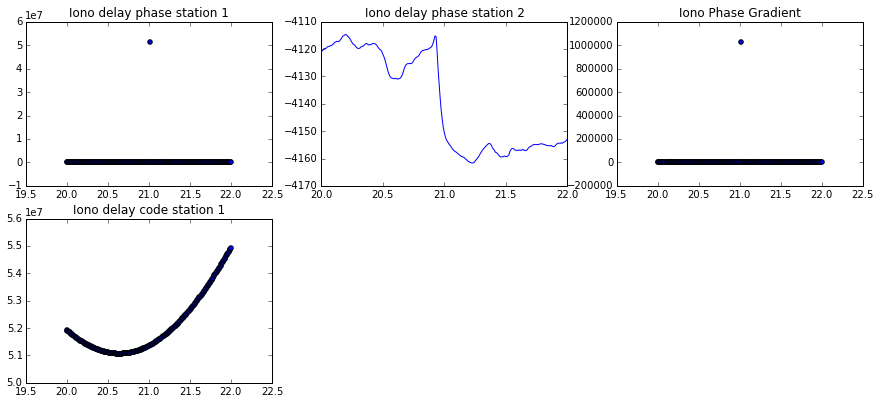

In [230]:
#t1,t2,tc1,tp1,tp2 Icode1 Iphase1 Iphase2
D=[]
gg=[]#gradient
IC1,IPh1,IPh2=[],[],[]
for time in tcommon:
    d=np.sqrt((Iphase1[time][1][0]-Iphase2[time][1][0])**2+(Iphase1[time][1][1]-Iphase2[time][1][1])**2+(Iphase1[time][1][2]-Iphase2[time][1][2])**2)/1000
    D.append(d)
    g=np.abs(Iphase1[time][0]-Iphase2[time][0])
    gg.append(g)
    IC1.append(Icode1[time][0])
    IPh1.append(Iphase1[time][0])
    IPh2.append(Iphase2[time][0])
    

D=np.array(D)
gg=np.array(gg)
t=np.array(tcommon)/3600 
IC1=np.array(IC1)
IPh1=np.array(IPh1)
IPh2=np.array(IPh2)

plt.figure(figsize=(15,10))
plt.subplot(3,3,1)
plt.title("Iono delay phase station 1")
plt.scatter(t,IPh1)
plt.subplot(3,3,2)
plt.title("Iono delay phase station 2")
plt.plot(t,IPh2)
plt.subplot(3,3,3)
plt.title("Iono Phase Gradient")
plt.scatter(t,gg/D)
plt.subplot(3,3,4)
plt.title("Iono delay code station 1")
plt.scatter(t,IC1)

###Iono Delay [slant] Gradient

238 238 82040.5382865 84663.9837182
-11.7470237929 43.6531762961
-4161.65576543 -4114.68203404


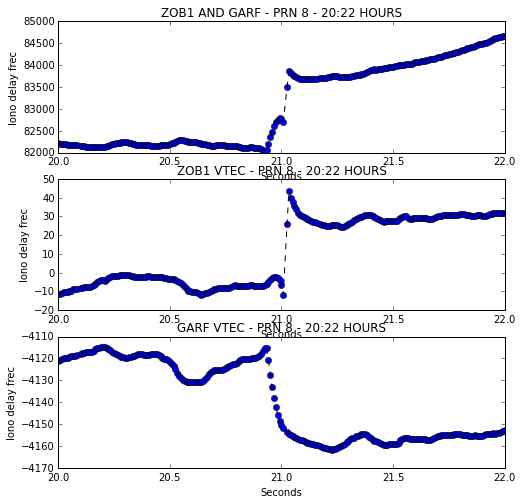

In [231]:
def slant(Iphase1,Iphase2,tcommon,error=None):
    gradient=[] #iono slopes
    Id1,Id2,t=[],[],[]
    for time in tcommon:
        g=np.abs(Iphase1[time][0]-Iphase2[time][0])*1000 #mm
        #distance between IPP's (Km)
        d=np.sqrt((Iphase1[time][1][0]-Iphase2[time][1][0])**2+(Iphase1[time][1][1]-Iphase2[time][1][1])**2+(Iphase1[time][1][2]-Iphase2[time][1][2])**2)/1000
        if (g/d)<error or error ==None:
            gradient.append(g/d)
            t.append(time)
            Id1.append(Iphase1[time][0])
            Id2.append(Iphase2[time][0])
    print len(gradient),len(t), min(gradient),max(gradient)
    print min(Id1),max(Id1)
    print min(Id2),max(Id2)
    t=np.array(t)/3600
    gradient=np.array(gradient)
    Id1=np.array(Id1)
    Id2=np.array(Id2)
    return t,Id1,Id2,gradient

t,Id1,Id2,gradient=slant(Iphase1,Iphase2,tcommon,5e8)
#t,Id1,Id2,gradient=slant(Iphase1,Iphase2,tcommon,4e9)
plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
plt.title("ZOB1 AND GARF - PRN 8 - 20:22 HOURS")
plt.xlabel("Seconds")
plt.ylabel("Iono delay frec")
plt.plot(t,gradient,'bo')
plt.plot(t,gradient,'k--', markerfacecolor='blue')

plt.subplot(3,1,2)
plt.title("ZOB1 VTEC - PRN 8 - 20:22 HOURS")
plt.xlabel("Seconds")
plt.ylabel("Iono delay frec")
plt.plot(t,Id1,'bo')
plt.plot(t,Id1,'k--', markerfacecolor='blue')


plt.subplot(3,1,3)
plt.title("GARF VTEC - PRN 8 - 20:22 HOURS")
plt.xlabel("Seconds")
plt.ylabel("Iono delay frec")
plt.plot(t,Id2,'bo')
plt.plot(t,Id2,'k--', markerfacecolor='blue')


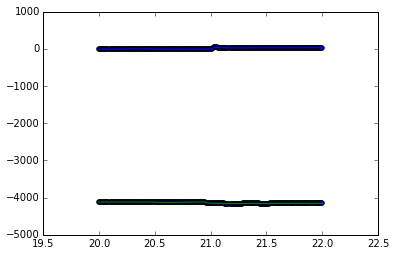

In [232]:
plt.plot(t,Id1)
plt.scatter(t,Id1)
plt.scatter(t,Id2)
plt.plot(t,Id2)

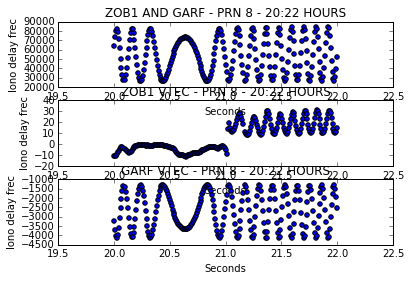

In [233]:
def vtec(VTECphase1,VTECphase2,tcommon,error=None):
    gradient=[] #iono slopes
    VTEC1,VTEC2,t=[],[],[]
    for time in tcommon:
        g=np.abs(VTECphase1[time][0]-VTECphase2[time][0])*1000 #mm
        #distance between IPP's (Km)
        d=np.sqrt((VTECphase1[time][1][0]-VTECphase2[time][1][0])**2+(VTECphase1[time][1][1]-VTECphase2[time][1][1])**2+(VTECphase1[time][1][2]-VTECphase2[time][1][2])**2)/1000
        if (g/d)<error or error ==None:
            gradient.append(g/d)
            t.append(time)
            VTEC1.append(VTECphase1[time][0])
            VTEC2.append(VTECphase2[time][0])
    
    t=np.array(t)/3600
    gradient=np.array(gradient)
    VTEC1=np.array(VTEC1)
    VTEC2=np.array(VTEC2)
    return t,VTEC1,VTEC2,gradient


t,VTEC1,VTEC2,gradient=vtec(VTECphase1,VTECphase2,tcommon,error=1e8)
plt.subplot(3,1,1)
plt.title("ZOB1 AND GARF - PRN 8 - 20:22 HOURS")
plt.xlabel("Seconds")
plt.ylabel("Iono delay frec")
plt.scatter(t,gradient)

plt.subplot(3,1,2)
plt.title("ZOB1 VTEC - PRN 8 - 20:22 HOURS")
plt.xlabel("Seconds")
plt.ylabel("Iono delay frec")
plt.scatter(t,VTEC1)

plt.subplot(3,1,3)
plt.title("GARF VTEC - PRN 8 - 20:22 HOURS")
plt.xlabel("Seconds")
plt.ylabel("Iono delay frec")
plt.scatter(t,VTEC2)




##Iono gradient WOOS/GARF PRN 26 20.7-21.3 hours 11/20/2003

In [234]:
st1=["data/woos324.03.n","data/woos324.03.o"]
st2=["data/garf324.03.n","data/garf3240.03o"]
t1,t2,tc1,tp1,tc2,tp2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2=gradient_stationpair(st1,st2,"GPS 26")

Estacion 1
Observaciones totales del satelite:  757
Observaciones con ambos codigos p1 y p2 :  0
Observaciones con ambas L1 y L2:  757
Estacion 2
Observaciones totales del satelite:  761
Observaciones con ambos codigos p1 y p2 :  0
Observaciones con ambas L1 y L2:  761


In [235]:
atp1=np.array(tp1)
atp2=np.array(tp2)
#Nos quedamos con los datos entre las 20.7 y 21.3 horas
datos1=atp1[(atp1>=74520) & (atp1<=76680)]
print np.size(datos1)
datos2=atp2[(atp2>=74520) & (atp2<=76680)]
print np.size(datos2)

72
73


In [236]:
print datos1[0:9]+1#estan corridos?
print datos2[1:10]

[ 74550.  74580.  74610.  74640.  74670.  74700.  74730.  74760.  74790.]
[ 74550.  74580.  74610.  74640.  74670.  74700.  74730.  74760.  74790.]


In [237]:
tcommon=np.intersect1d(datos1+1,datos2)
print np.size(tcommon)
print np.min(tcommon),np.max(tcommon)
tcommon[(tcommon>=72000.0) & (tcommon<=79200)]

72
74550.0 76680.0


array([ 74550.,  74580.,  74610.,  74640.,  74670.,  74700.,  74730.,
        74760.,  74790.,  74820.,  74850.,  74880.,  74910.,  74940.,
        74970.,  75000.,  75030.,  75060.,  75090.,  75120.,  75150.,
        75180.,  75210.,  75240.,  75270.,  75300.,  75330.,  75360.,
        75390.,  75420.,  75450.,  75480.,  75510.,  75540.,  75570.,
        75600.,  75630.,  75660.,  75690.,  75720.,  75750.,  75780.,
        75810.,  75840.,  75870.,  75900.,  75930.,  75960.,  75990.,
        76020.,  76050.,  76080.,  76110.,  76140.,  76170.,  76200.,
        76230.,  76260.,  76290.,  76320.,  76350.,  76380.,  76410.,
        76440.,  76470.,  76500.,  76530.,  76560.,  76590.,  76620.,
        76650.,  76680.])

61 61 833.041717239 1548.09103909


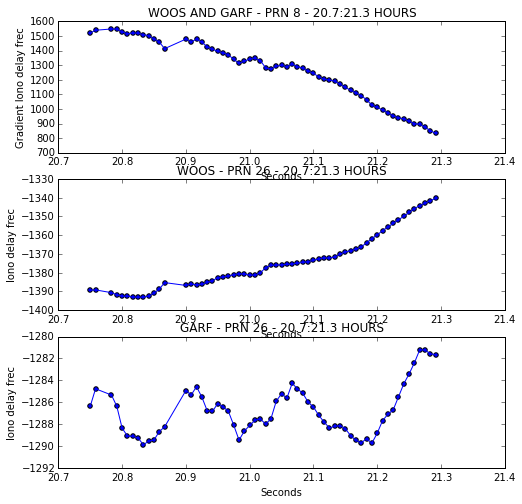

In [238]:
gradient=[] #iono slopes
#print "Delay 0: ",Iphase1[77160.][0] #delay
#print "IPP: ",Iphase1[77160.][1] #posicion del ipp
t=[]
Id1,Id2=[],[]
for time in tcommon:
    g=np.abs(Iphase1[time-1][0]-Iphase2[time][0])*1000 #mm
    #distance between IPP's (Km)
    d=np.sqrt((Iphase1[time-1][1][0]-Iphase2[time][1][0])**2+(Iphase1[time-1][1][1]-Iphase2[time][1][1])**2+(Iphase1[time-1][1][2]-Iphase2[time][1][2])**2)/1000
    if (g/d)<12e3:
        gradient.append(g/d)
        t.append(time)
        Id1.append(Iphase1[time-1][0])
        Id2.append(Iphase2[time][0])
t=np.array(t)/3600

print len(gradient),len(t), min(gradient),max(gradient)
plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
plt.title("WOOS AND GARF - PRN 8 - 20.7:21.3 HOURS")
plt.xlabel("Seconds")
plt.ylabel("Gradient Iono delay frec")
plt.scatter(t,gradient)
plt.plot(t,gradient)

plt.subplot(3,1,2)
plt.title("WOOS - PRN 26 - 20.7:21.3 HOURS")
plt.xlabel("Seconds")
plt.ylabel("Iono delay frec")
plt.plot(t,Id1)
plt.scatter(t,Id1)


plt.subplot(3,1,3)
plt.title("GARF - PRN 26 - 20.7:21.3 HOURS")
plt.xlabel("Seconds")
plt.ylabel("Iono delay frec")
plt.scatter(t,Id2)
plt.plot(t,Id2)

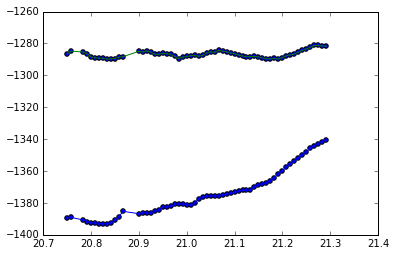

In [239]:
plt.plot(t,Id1)
plt.scatter(t,Id1)
plt.scatter(t,Id2)
plt.plot(t,Id2)